In [1]:
#Importing Necessary Libraries

#Data Manipulation/Calculation Libraries
import pandas as pd
import numpy as np
import math

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#NLP 
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from fuzzywuzzy import fuzz
from nltk import word_tokenize
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from tqdm import tqdm_notebook

#ML Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [2]:
train = pd.read_csv("/Users/raghavagovil/Desktop/Data Science Projects/Quora Project Data /train.csv")
train.question1 = train.question1.astype(str)
train.question2 = train.question2.astype(str)
test = pd.read_csv("/Users/raghavagovil/Desktop/Data Science Projects/Quora Project Data /test.csv")
test.question1 = test.question1.astype(str)
test.question2 = test.question1.astype(str)

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
train.shape

(404290, 6)

In [5]:
print("Total number of question pairs for training: {}".format(len(train)))
print("Duplicate pairs: {}%".format(round(train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780


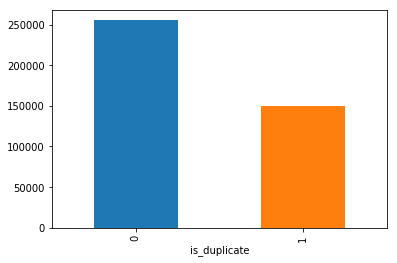

In [6]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
def clean_text(text):
    #Convert to lower case
    text = text.lower().split()
    #Lemmatizing the text
    #lemma = WordNetLemmatizer()
    #normalized = " ".join(lemma.lemmatize(word, pos = "v") for word in text.split())
    #Removing White spaces
    #normalized = normalized.replace('\d+', '')
    #normalized = normalized.strip()
    #Tokenize and extract words that are alpha-numeric
    #tokens = word_tokenize(normalized)
    #cleaned = [word for word in tokens if word.isalpha()]
    #Create a dictionary of stem-words such as "at" and 
    #"the" that don't contribute to meaning and remove them from the list
    stop_words = set(stopwords.words('english'))
    words = [w for w in text if not w in stop_words]
    return words

train["question1.clean"] = [clean_text(text) for text in train["question1"]]
train["question2.clean"] = [clean_text(text) for text in train["question2"]]
test["question1.clean"] = [clean_text(text) for text in test["question1"]]
test["question2.clean"] = [clean_text(text) for text in test["question2"]]

In [8]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,question1.clean,question2.clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market?]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (koh-i-noor), diamond?]","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns?]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely?, solve, it?]","[find, remainder, [math]23^{24}[/math], divide..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar,, salt,, ...","[fish, would, survive, salt, water?]"
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,"[astrology:, capricorn, sun, cap, moon, cap, r...","[i'm, triple, capricorn, (sun,, moon, ascendan..."
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,"[buy, tiago?]","[keeps, childern, active, far, phone, video, g..."
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,"[good, geologist?]","[great, geologist?]"
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,"[use, シ, instead, し?]","[use, ""&"", instead, ""and""?]"
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,"[motorola, (company):, hack, charter, motoroll...","[hack, motorola, dcx3400, free, internet?]"


In [9]:
#Word2Vec Library
import gensim
from gensim.models import Word2Vec

model = gensim.models.KeyedVectors.load_word2vec_format('/Users/raghavagovil/Desktop/Data Science Projects/Quora Project Data /GoogleNews-vectors-negative300.bin.gz', binary=True)

In [10]:
#Finding Normalized Distance between the word embeddings
model.init_sims(replace=True)
train['wmd'] = train.apply(lambda x: model.wmdistance(x['question1.clean'], x['question2.clean']), axis=1)
test['wmd'] = test.apply(lambda x: model.wmdistance(x['question1.clean'], x['question2.clean']), axis=1)

In [11]:
#New Features
train['len_q1'] = train.question1.apply(lambda x: len(str(x)))
train['len_q2'] = train.question2.apply(lambda x: len(str(x)))
train['diff_len'] = train.len_q1 - train.len_q2
train['len_char_q1'] = train.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
train['len_char_q2'] = train.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
train['len_word_q1'] = train.question1.apply(lambda x: len(str(x).split()))
train['len_word_q2'] = train.question2.apply(lambda x: len(str(x).split()))
train['common_words'] = train.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [12]:
test['len_q1'] = test.question1.apply(lambda x: len(str(x)))
test['len_q2'] = test.question2.apply(lambda x: len(str(x)))
test['diff_len'] = test.len_q1 - test.len_q2
test['len_char_q1'] = test.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
test['len_char_q2'] = test.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
test['len_word_q1'] = test.question1.apply(lambda x: len(str(x).split()))
test['len_word_q2'] = test.question2.apply(lambda x: len(str(x).split()))
test['common_words'] = test.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [13]:
#New Fuzz Features
train['fuzz_ratio'] = train.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_partial_ratio'] = train.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_partial_token_set_ratio'] = train.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_partial_token_sort_ratio'] = train.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_token_set_ratio'] = train.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_token_sort_ratio'] = train.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [14]:
test['fuzz_ratio'] = test.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_partial_ratio'] = test.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_partial_token_set_ratio'] = test.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_partial_token_sort_ratio'] = test.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_token_set_ratio'] = test.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_token_sort_ratio'] = test.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [15]:
pd.set_option('display.max_columns', 500)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1.clean,question2.clean,wmd,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market?]",0.217555,66,57,9,20,20,14,12,10,93,98,100,89,100,93
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (koh-i-noor), diamond?]","[would, happen, indian, government, stole, koh...",1.368796,51,88,-37,21,29,8,13,4,65,73,100,75,86,63
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns?]",0.639209,73,59,14,25,24,14,10,4,55,53,100,71,66,66
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely?, solve, it?]","[find, remainder, [math]23^{24}[/math], divide...",1.263719,50,65,-15,19,26,11,9,0,28,30,37,38,36,36
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar,, salt,, ...","[fish, would, survive, salt, water?]",1.240908,76,39,37,25,18,13,7,2,45,54,100,63,67,47


In [16]:
#Converting sentences to vectors
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

question1_vectors = np.zeros((train.shape[0], 300))
for i, q in enumerate(tqdm_notebook(train.question1.values)):
    question1_vectors[i, :] = sent2vec(q)
    
question2_vectors  = np.zeros((train.shape[0], 300))
for i, q in enumerate(tqdm_notebook(train.question2.values)):
    question2_vectors[i, :] = sent2vec(q)
    
questiont1_vectors = np.zeros((test.shape[0], 300))
for i, q in enumerate(tqdm_notebook(test.question1.values)):
    questiont1_vectors[i, :] = sent2vec(q)
    
questiont2_vectors  = np.zeros((test.shape[0], 300))
for i, q in enumerate(tqdm_notebook(test.question2.values)):
    questiont2_vectors[i, :] = sent2vec(q)

HBox(children=(IntProgress(value=0, max=404290), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


HBox(children=(IntProgress(value=0, max=404290), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2345796), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2345796), HTML(value='')))

In [17]:
#Calculating Various Distances between the two questions (Now converted to vectors)
train['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
train['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
train['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
train['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]

/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:763: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.double(unequal_nonzero.sum()) / np.double(nonzero.sum())
/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:980: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


In [18]:
test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(questiont1_vectors), np.nan_to_num(questiont2_vectors))]
test['skew_q1vec'] = [skew(x) for x in np.nan_to_num(questiont1_vectors)]
test['skew_q2vec'] = [skew(x) for x in np.nan_to_num(questiont2_vectors)]
test['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(questiont1_vectors)]
test['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(questiont2_vectors)]

/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:763: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.double(unequal_nonzero.sum()) / np.double(nonzero.sum())
/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:980: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


In [21]:
#test.to_csv(r'/Users/raghavagovil/Desktop/Data Science Projects/Quora Project Data .csv')

In [23]:
#train.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
test.drop(['test_id'], axis=1, inplace=True)

In [24]:
test.isnull().sum()

question1                            0
question2                            0
question1.clean                      0
question2.clean                      0
wmd                                  0
len_q1                               0
len_q2                               0
diff_len                             0
len_char_q1                          0
len_char_q2                          0
len_word_q1                          0
len_word_q2                          0
common_words                         0
fuzz_ratio                           0
fuzz_partial_ratio                   0
fuzz_partial_token_set_ratio         0
fuzz_partial_token_sort_ratio        0
fuzz_token_set_ratio                 0
fuzz_token_sort_ratio                0
cosine_distance                  19406
cityblock_distance                   0
jaccard_distance                 19406
canberra_distance                    0
euclidean_distance                   0
minkowski_distance                   0
braycurtis_distance      

In [26]:
train = train[pd.notnull(train['cosine_distance'])]
train = train[pd.notnull(train['jaccard_distance'])]
train = train[pd.notnull(train['braycurtis_distance'])]
test = test[pd.notnull(test['cosine_distance'])]
test = test[pd.notnull(test['jaccard_distance'])]
test = test[pd.notnull(test['braycurtis_distance'])]
train.shape

(402515, 31)

In [27]:
train1 = train
train.drop(['question1', 'question2', 'question1.clean', 'question2.clean'], axis=1, inplace=True)
test.drop(['question1', 'question2', 'question1.clean', 'question2.clean'], axis=1, inplace=True)

In [35]:
test.head()

,wmd,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0.0,57,57,0,21,21,11,11,11,100,100,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060989,0.060989,0.206236,0.206236
1,0.0,66,66,0,24,24,14,14,14,100,100,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018201,-0.018201,0.150158,0.150158
2,0.0,60,60,0,21,21,14,14,12,100,100,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042803,0.042803,-0.466346,-0.466346
3,0.0,27,27,0,16,16,4,4,4,100,100,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094811,0.094811,-0.150121,-0.150121
4,0.0,32,32,0,17,17,4,4,4,100,100,100,100,100,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003651,-0.003651,-0.100281,-0.100281


In [ ]:
#train.to_csv(r'/Users/raghavagovil/Desktop/Data Science Projects/Quora Project Data .csv')

In [ ]:
#train.replace([np.inf, -np.inf], np.nan)
#train.iloc[:,1:27] = train.iloc[:,1:27].astype('float64')
#train.dtypes

In [ ]:
#X = train.iloc[:,1:27]
#y = train['is_duplicate']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
X_train = train.iloc[:,1:27]
y_train = train['is_duplicate']
X_test = test

In [ ]:
#model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train.values.ravel()) 
#prediction = model.predict(X_test)
#cm = confusion_matrix(y_test, prediction)  
#print(cm)  
#print('Accuracy', accuracy_score(y_test, prediction))
#print(classification_report(y_test, prediction))


In [37]:
model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train.values.ravel()) 
prediction = model.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
